# Modelling Sale Price

## Objectives

* Fit a regression model to predict sale price.
* Use a hyperparameter search to determine which features are most important for successful model training.

## Inputs

* outputs/datasets/datacollection/house_prices_records.csv 

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict sale price
* Feature importance Plot

## Notebook in Relation to CRISP-DM

* This notebook forms the Modelling and Evaluation phase of CRISP-DM.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/CI-PP5-Peter-Regan-Heritage-Housing-Project/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/CI-PP5-Peter-Regan-Heritage-Housing-Project'

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv("/workspaces/CI-PP5-Peter-Regan-Heritage-Housing-Project/outputs/datasets/datacollection/house_prices_records.csv")
print(df.shape)
df.head()

(1460, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# ML Pipeline

The pipeline will be built based off of the conclusions of the feature engineering notebook. The functions used have been taken from Code Institute's Churnometer walkthrough project.

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.outliers   import Winsorizer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection, DropFeatures
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimisation(model):
    pipeline_base = Pipeline([

        # Data Cleaning - Steps Outlined in Data Cleaning Notebook
        ("DropFeatures", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        
        ("MedianImputation", MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage'])),

        ("ArbitraryNumberImputer",ArbitraryNumberImputer(arbitrary_number=0, variables=['2ndFlrSF','MasVnrArea'])),

        ("CategoricalImputer", CategoricalImputer(imputation_method='missing',fill_value='None', variables=['GarageFinish','BsmtFinType1'])),

        # Feature Engineering - see Feature Engineering Notebook
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', 
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(variables=['LotArea'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['GarageArea'])),

        ("PowerTransformer", vt.PowerTransformer(variables=['2ndFlrSF', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'])),
                                      
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        # Feature Scaling - Standardise features by removing the mean and scaling to unit variance.
        ("scaler", StandardScaler()),

        # Feature Selection - Meta-transformer for selecting features based on importance weights.
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base



/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


The custom class used for hyperparamter optimization below again comes from Code Institute's Churnometer walkthrough project.

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimisation(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

---

# Split Train and Test Sets

The data will be split into train and test sets with a standard 80% - 20% split. The train set will be 80% of the data.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


# Grid Search CV - SKLearn

## Default Hyperparameters

We will use the default hyperparameters first in order to find the most suitable algorithm.

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

We will use the default hyperparameters to do a hyperparameter optimisation search.

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]



Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

Display the results of the search.

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.683053,0.789425,0.851642,0.066298
0,LinearRegression,0.69588,0.772941,0.847604,0.051437
5,GradientBoostingRegressor,0.575323,0.766273,0.841736,0.098117
2,RandomForestRegressor,0.632989,0.765666,0.841393,0.074442
4,AdaBoostRegressor,0.643592,0.739545,0.77732,0.048793
6,XGBRegressor,0.516199,0.714373,0.798197,0.100734
1,DecisionTreeRegressor,0.513775,0.626422,0.700427,0.072109


The Extra Trees Regressor algorithm has provided the best mean score of 0.789425.

## Find Best Hyperparameters for Selected Algorithm

First we decide the model and parameters to be used for the hyperparameter search. The values used in this search are the suggested values from Code Institute's lessons on Scikit-Learn.

In [11]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            }
  }

Now we perform a more thorough search of these hyperparameters.

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

Display the results.

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head()

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
4,ExtraTreesRegressor,0.745892,0.797752,0.839578,0.037003,None,1,50,50
28,ExtraTreesRegressor,0.745892,0.797752,0.839578,0.037003,15,1,50,50
3,ExtraTreesRegressor,0.739033,0.796672,0.837143,0.038695,None,1,50,100
27,ExtraTreesRegressor,0.738256,0.796485,0.837143,0.038954,15,1,50,100
5,ExtraTreesRegressor,0.740816,0.796394,0.834893,0.037854,None,1,50,150


The top 5 results all have mean scores above 0.796, and improvement on using the default hyperparameters, so these hyperparameters will be used. Now we will pick the best model and hyperparameters to use in the pipeline. 

In [14]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

In [15]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('DropFeatures',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('MedianImputation',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                ('ArbitraryNumberImputer',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('CategoricalImputer',
                 CategoricalImputer(fill_value='N...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                     

# Assess Feature Importance

The following functions are taken from Code Institute's Churnometer walkthrough project.

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', '1stFlrSF']


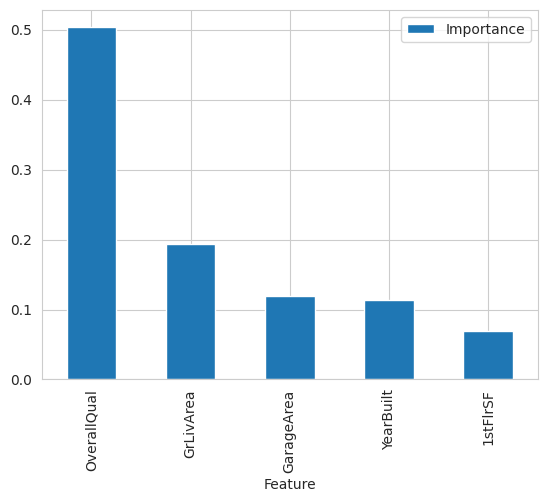

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 9
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

# Evaluate on Train and Test Sets

This code is taken from Code Institute's Churnometer walkthrough project.

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

We apply these performance evaluating functions to the selected pipeline.

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

Model Evaluation 

* Train Set
R2 Score: 0.84
Mean Absolute Error: 20050.967
Mean Squared Error: 985130733.584
Root Mean Squared Error: 31386.792


* Test Set
R2 Score: 0.774
Mean Absolute Error: 21762.904
Mean Squared Error: 1562963239.193
Root Mean Squared Error: 39534.33




The R2 score for the train set is 0.84. The R2 score for the test set is 0.774. The business requirement for the client is an R2 score over 0.75. As the pipeline manages to achieve this for both train and test sets, we can assume it is satisfactory for making reliable predictions and satisfying the client's business requirements.

# Rewriting the ML Pipeline for Modelling

Now that we have established which property features our most important with regard to their impact on the sale price, and that our selected pipeline performs well enough to satisfy the client's business requirements, we will rewrite the pipeline using the five most important features to train the model.

This also means that features and their associated transformations that were included in our earlier version of the pipeline will be removed from the new pipeline if they are not included in the top five most important features identified earlier.

Smart Correlated Selection and Feature Selection will also be removed from the pipeline because we have now already identified the most important features.


In [ ]:
def PipelineOptimisation(model):
    pipeline_base = Pipeline([

        # Feature Engineering
        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['GarageArea'])),

        # Feature Scaling
        ("scaler", StandardScaler()),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

## Repeat Process Conducted on Initially Proposed Pipeline

The same steps are undertaken on this pipeline as were on the our initially proposed pipeline in this notebook. This is to verify that its performance still meets requirements.

## Split Train and Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1),
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",X_test.shape, y_test.shape)

Filter the datasets to include only the top five most important features.

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head()

Conduct hyperparameter optimisation search on selected model and parameters.

In [ ]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0)
}

params_search = {
    "ExtraTreesRegressor": {
        'model__max_depth': [15],
        'model__min_samples_leaf': [1],
        'model__min_samples_split': [50],
        'model__n_estimators': [150]}
}

Use Grid Search CV from Scikit-Learn as before.

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search,
                                          params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Display results.

In [ ]:
(grid_search_summary, grid_search_pipelines) = search.score_summary(sort_by='mean_score')
grid_search_summary

We can see there is a very small improvement to 0.809 in the R2 score when fitting the pipeline only with the five most important features.

Our optimised model based upon this particular data cleaning and feature engineering process can now be built. It is possible to consider slightly different outcomes if different transformations had been used in the cleaning and engineering process, however the differences are unlikley to be significant and as this pipeline satisfies the business requirements, repeating the process is not necessary.

In [ ]:
best_model = grid_search_summary.iloc[0, 0]
best_model

In [ ]:
final_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
final_regressor_pipeline

Finally, let us test this model's performance on the train and test sets.

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, final_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, final_regressor_pipeline)

The R2 score for the train set is 0.839. The R2 score for the test set is 0.773. Both of these scores are above the client's business requirement to have an R2 score of over 0.75. This pipeline is suitable for use.

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

These files will be generated and pushed to the repo:
- Train dataset
- Test dataset
- Modelling pipeline
- Features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: Features and Target

In [ ]:
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train.head()

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: Features and Target

In [ ]:
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test.head()

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling Pipeline

In [ ]:
best_regressor_pipeline

In [ ]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")

## Feature Importance Plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

# Conclusions 

As we can see, the variables with the greatest impact on sale price are: OverallQual, GrLivArea, YearBuilt, GarageArea, 1stFlrSF.

This indiciates that bigger houses, houses in overall good condition and newer houses tend to have a higher sale price than those that don't meet these criteria.

Outputs can now be cleared from this notebook and files can be pushed to the repository.

